# Reinforcement Learning

This notebook is based off of Hands On Chapter 16.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Note: there may be minor differences between the output of this notebook and the examples shown in the book. You can safely ignore these differences. They are mainly due to the fact that most of the environments provided by OpenAI gym have some randomness.

# Introduction to OpenAI gym

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's start by importing `gym`:

In [2]:
import gym

Next we will load the MsPacman environment, version 0. The make() function creates an environment for MsPacman.

In [3]:
env = gym.make('MsPacman-v0')

Let's initialize the environment by calling is `reset()` method. This returns an observation:

In [4]:
obs = env.reset()

Observations vary depending on the environment. In this case it is an RGB image represented as a 3D NumPy array of shape [width, height, channels] (with 3 channels: Red, Green and Blue). In other environments it may return different objects, as we will see later.

In [5]:
obs.shape

(210, 160, 3)

An environment can be visualized by calling its `render()` method, and you can pick the rendering mode (the rendering options depend on the environment). In this example we will set `mode="rgb_array"` to get an image of the environment as a NumPy array:

In [6]:
img = env.render(mode="rgb_array")

Let's plot this image:

<IPython.core.display.Javascript object>


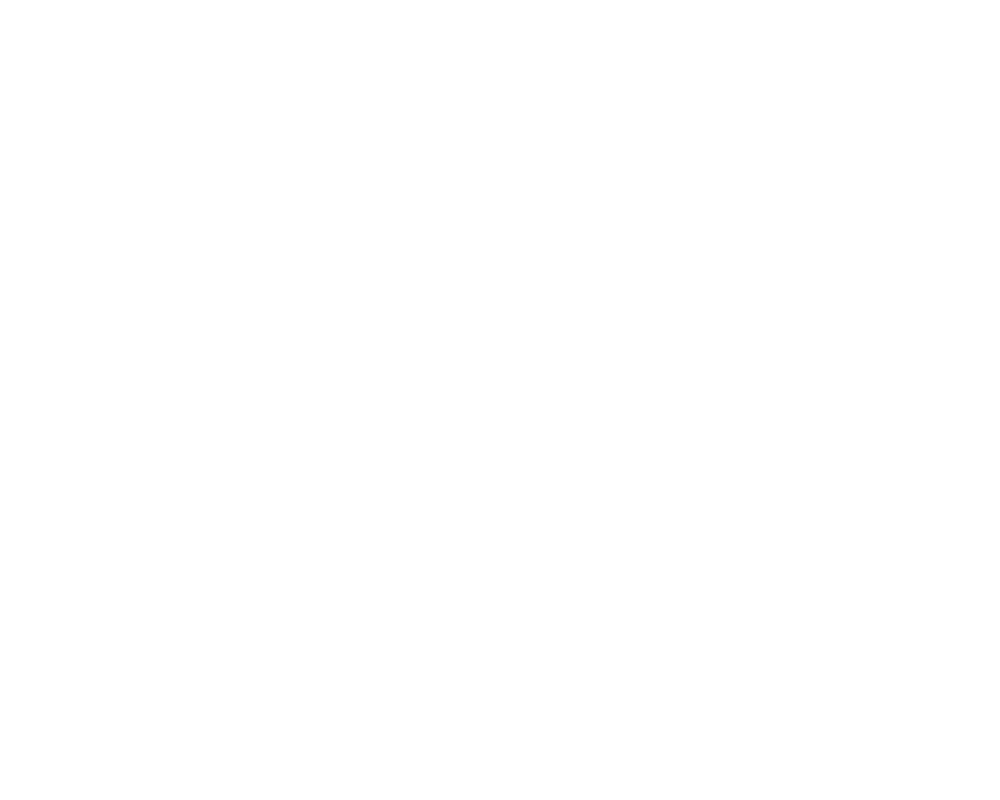

Saving figure MsPacman


FileNotFoundError: [Errno 2] No such file or directory: './images/rl/MsPacman.png'

In [7]:
plt.figure(figsize=(5,4))
plt.imshow(img)
plt.axis("off")
save_fig("MsPacman")
plt.show()

Welcome back to the 1980s! :)

In this environment, the rendered image is simply equal to the observation (but in many environments this is not the case):

In [8]:
(img == obs).all()

True

Let's create a little helper function to plot an environment:

In [9]:
def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [10]:
env.action_space

Discrete(9)

`Discrete(9)` means that the possible actions are integers 0 through 8, which represents the 9 possible positions of the joystick (0=center, 1=up, 2=right, 3=left, 4=down, 5=upper-right, 6=upper-left, 7=lower-right, 8=lower-left).

Next we need to tell the environment which action to play, and it will compute the next step of the game. Let's go left for 110 steps, then lower left for 40 steps:

In [11]:
env.reset()
for step in range(110):
    env.step(3) #left
for step in range(40):
    env.step(8) #lower-left

Where are we now?

<IPython.core.display.Javascript object>


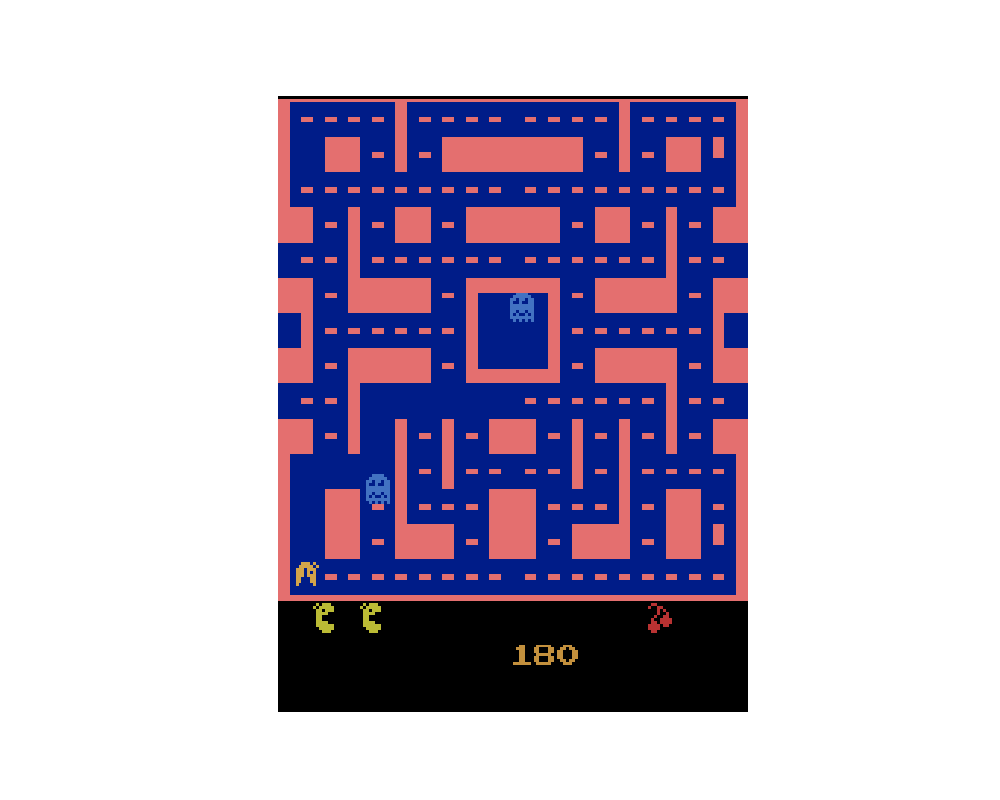

In [12]:
plot_environment(env)

The `step()` function actually returns several important objects:

In [13]:
obs, reward, done, info = env.step(0)

Obs is the new observation. The observation tells the agent what the environment looks like, as discussed earlier. This is a 210x160 RGB image:

In [14]:
obs.shape

(210, 160, 3)

The environment also tells the agent how much reward it got during the last step:

In [15]:
reward

0.0

When the _episode_ (in our case the game) is over, the environment returns `done=True`:

In [16]:
done

False

Finally, `info` is an environment-specific dictionary that can provide some extra information about the internal state of the environment. This is useful for debugging, but your agent should not use this information for learning (it would be cheating).

In [17]:
info

{'ale.lives': 3}

Let's play one full game (with 3 lives), by moving in random directions for 10 steps at a time, recording each frame:

In [18]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample() # play randomly
    obs, reward, done, info = env.step(action)
    if done:
        break

Now show the animation (it's a bit jittery within Jupyter):

In [19]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

<IPython.core.display.Javascript object>


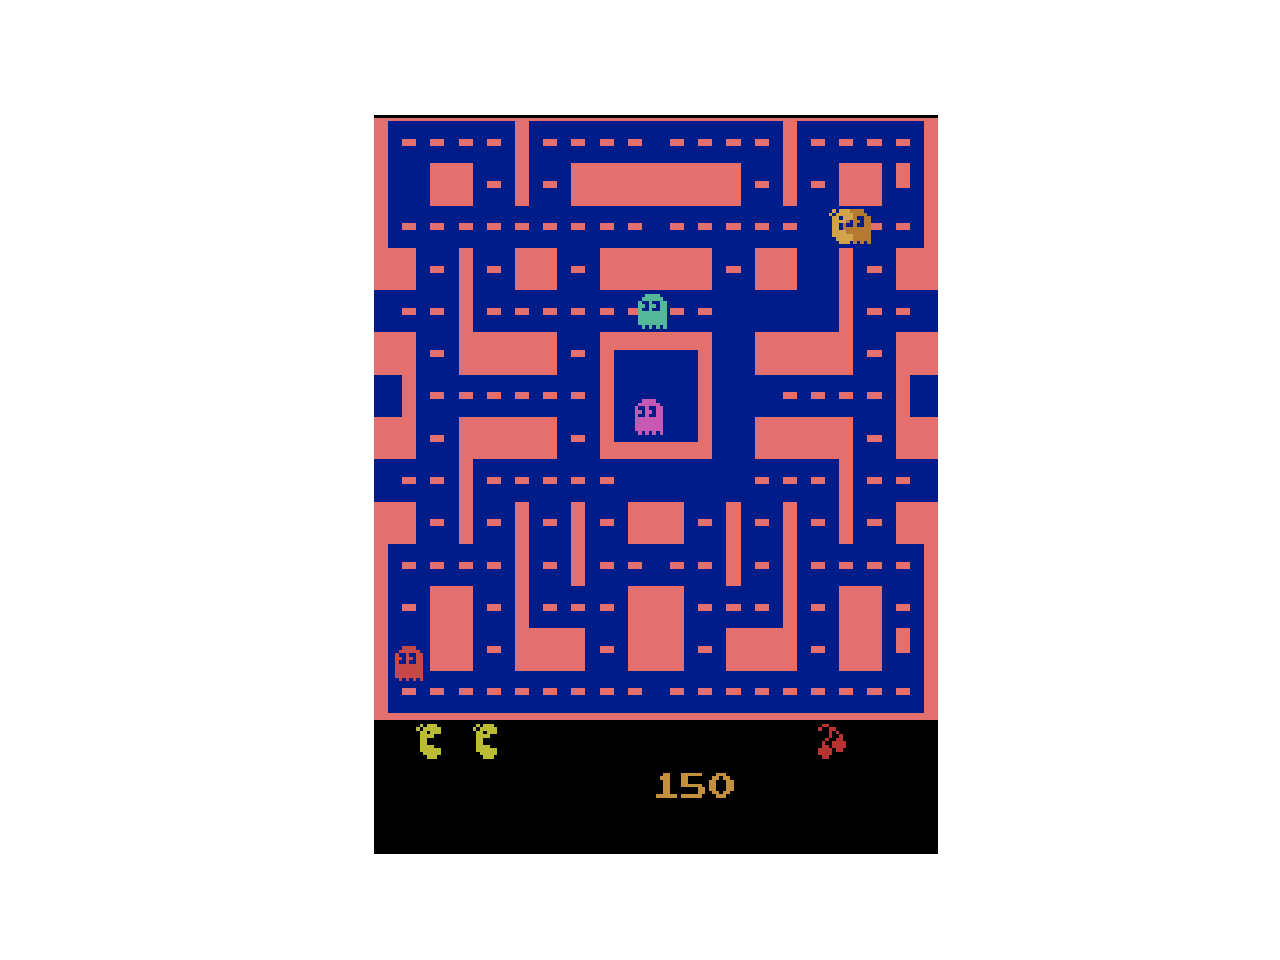

In [20]:
video = plot_animation(frames)
plt.show()

Once you have finished playing with an environment, you should close it to free up resources:

In [21]:
env.close()

**Question** This game was played by moving in random directions. How well do you think this worked based on the above animation?

To code our first learning agent, we will be using a simpler environment: the Cart-Pole. 

# A simple environment: the Cart-Pole

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [22]:
env = gym.make("CartPole-v0")

In [23]:
obs = env.reset()

In [24]:
obs

array([ 0.00053275, -0.00295448,  0.01485956,  0.03899026])

The observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity. Let's render the environment... unfortunately we need to fix an annoying rendering issue first.

## Fixing the rendering issue

Some environments (including the Cart-Pole) require access to your display, which opens up a separate window, even if you specify the `rgb_array` mode. In general you can safely ignore that window. However, if Jupyter is running on a headless server (ie. without a screen) it will raise an exception. One way to avoid this is to install a fake X server like Xvfb. We will **not** be installing this for this class, but the command is provided here if you want to try this out later. You can start Jupyter using the `xvfb-run` command:

    $ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook

If Jupyter is running on a headless server but you don't want to worry about Xvfb, then you can just use the following rendering function for the Cart-Pole. **This is what we will use for this class**:

In [25]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>


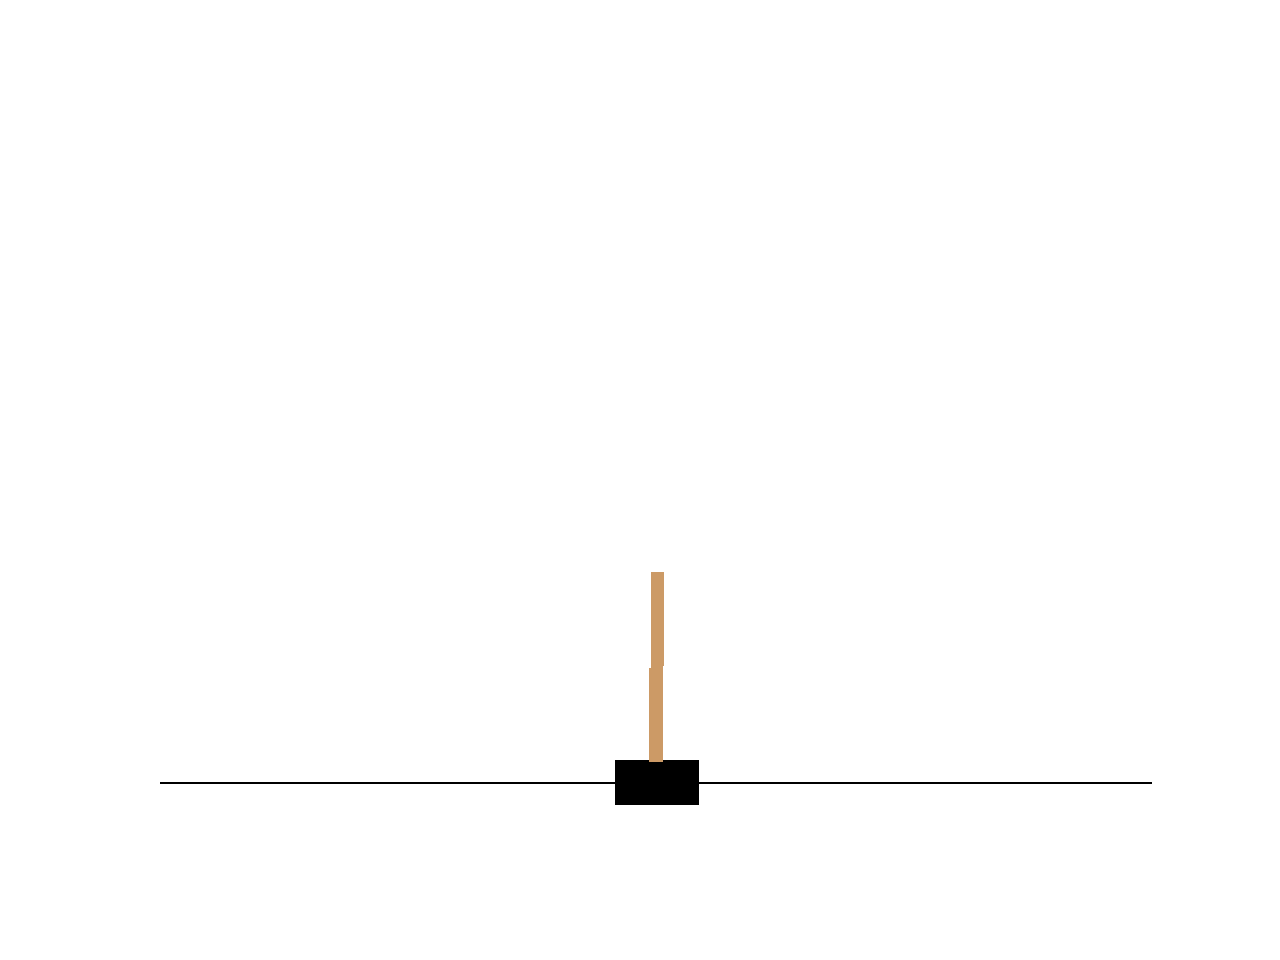

In [26]:
plot_cart_pole(env, obs)

Now let's look at the action space:

In [27]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left or towards the right. Let's push the cart left until the pole falls:

In [28]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

<IPython.core.display.Javascript object>


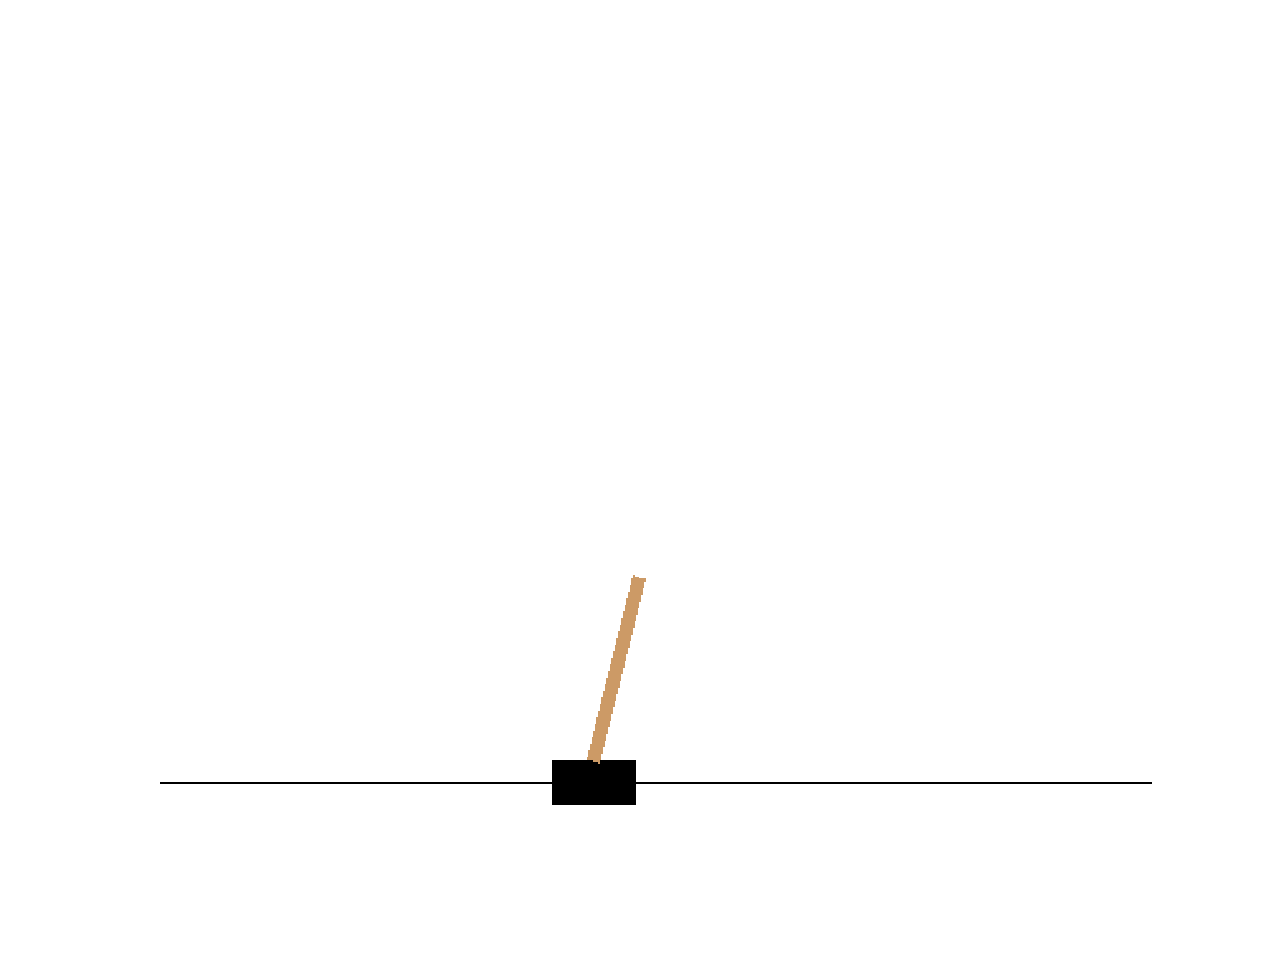

(-0.5, 599.5, 399.5, -0.5)

In [29]:
plt.close()  # or else nbagg sometimes plots in the previous cell
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis("off")
# save_fig("cart_pole_plot")

In [30]:
img.shape

(400, 600, 3)

Notice that the game is over when the pole tilts too much, not when it actually falls. Now let's reset the environment and push the cart to right instead:

In [31]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

<IPython.core.display.Javascript object>


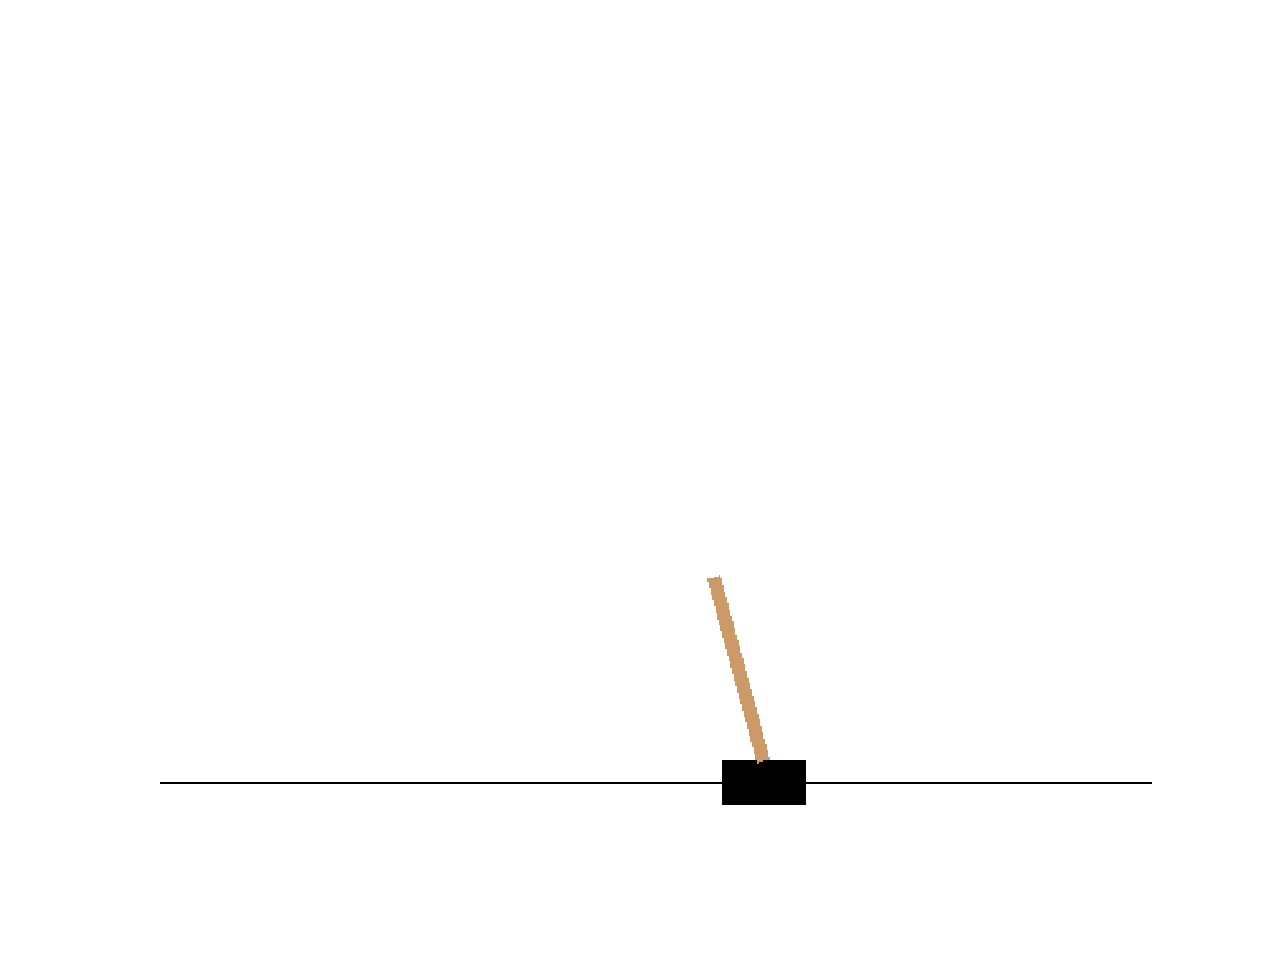

In [32]:
plot_cart_pole(env, obs)

Looks like it's doing what we're telling it to do. Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. We will run this policy to see the average rewards it gets over 500 episodes. Let's see if that works:

In [33]:
frames = []
totals = []

n_max_steps = 1000
n_change_steps = 10

# set for 500 episodes
for episode in range(500):

    # reset
    episode_rewards = 0
    obs = env.reset()

    # run through 1 episode of n_max_steps length
    for step in range(n_max_steps):

        # render the environment
        img = render_cart_pole(env, obs)
        frames.append(img)

        # hard-coded policy
        position, velocity, angle, angular_velocity = obs
        if angle < 0:
            action = 0
        else:
            action = 1

        # take a step
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    
    # save the reward
    totals.append(episode_rewards)    

<IPython.core.display.Javascript object>


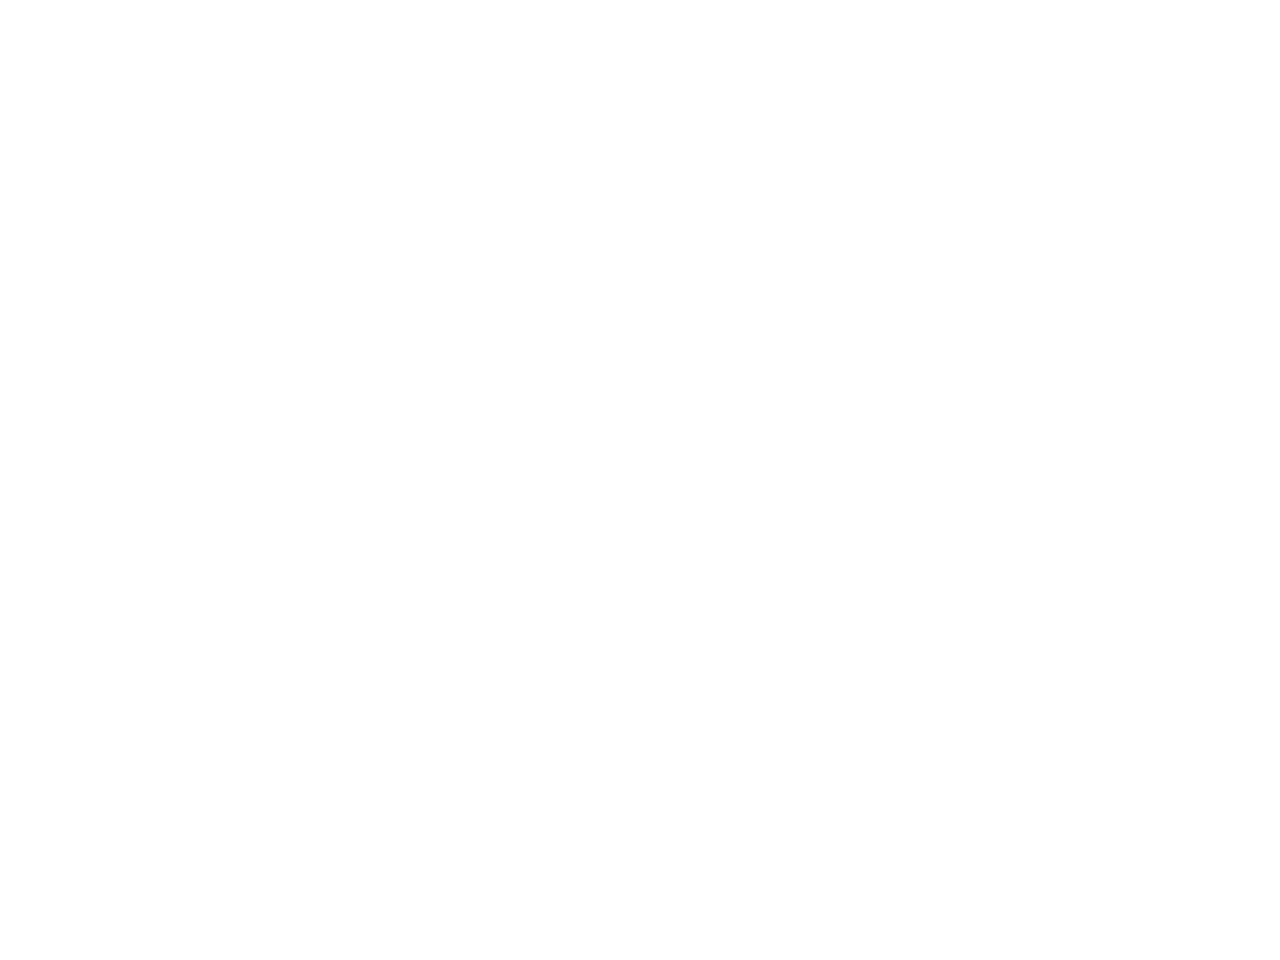

In [34]:
# let's display a video of all 500 episodes. 
# This cell may take 20-30 seconds to run.
# You should see the pole tilt too much and restart 500 times (if you watch that long).
video = plot_animation(frames)
plt.show()

In [35]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.536, 8.889808996823273, 24.0, 72.0)

Nope, the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. In fact, even with 500 tries, this policy never managed to keep the pole upright for more than
68 consecutive steps.

We will need to be smarter and come up with a better policy! Let's try to use a neural network as our policy.

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the action to take for each observation. To choose an action, the network will first estimate a probability for each action, then select an action randomly according to the estimated probabilities. In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

Note: instead of using the `fully_connected()` function from the `tensorflow.contrib.layers` module (as in the book), we now use the `dense()` function from the `tf.layers` module, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same.

The main differences relevant to this chapter are:
* the `_fn` suffix was removed in all the parameters that had it (for example the `activation_fn` parameter was renamed to `activation`).
* the `weights` parameter was renamed to `kernel`,
* the default activation is `None` instead of `tf.nn.relu`

In [36]:
import tensorflow as tf

# 1. Specify the network architecture
n_inputs = 4  # == env.observation_space.shape[0]
n_hidden = 4  # it's a simple task, we don't need more than this
n_outputs = 1 # only outputs the probability of accelerating left
initializer = tf.variance_scaling_initializer()

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
outputs = tf.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid,
                          kernel_initializer=initializer)

# 3. Select a random action based on the estimated probabilities
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.


In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we are picking a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

Let's randomly initialize this policy neural network and use it to play one game:

In [37]:
n_max_steps = 1000
frames = []

with tf.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

env.close()

Now let's look at how well this randomly initialized policy network performed:

<IPython.core.display.Javascript object>


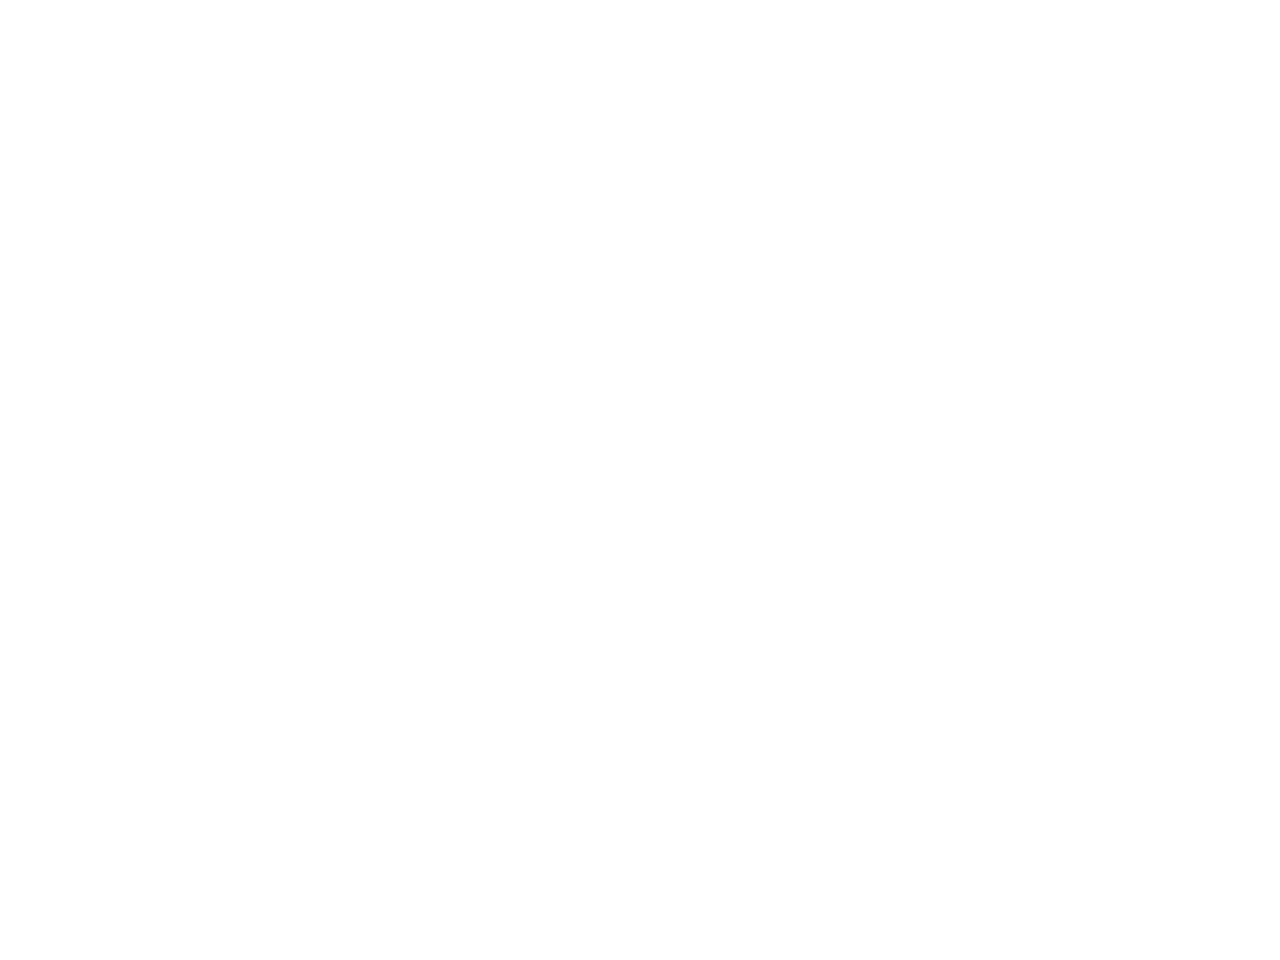

In [38]:
video = plot_animation(frames)
plt.show()

**Question** How well did this method do compared to our simple policy? Justify your answer.

Again, this didn't do too well. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right. The following code defines the same neural network but we add the target probabilities `y`, and the training operations (`cross_entropy`,  `optimizer` and `training_op`):

In [39]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits) # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

We can make the same net play in 10 different environments in parallel, and train for 1000 iterations. We also reset environments when they are done.

In [40]:
n_environments = 10
n_iterations = 1000

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations]) # if angle<0 we want proba(left)=1., or else proba(left)=0.
        action_val, _ = sess.run([action, training_op], feed_dict={X: np.array(observations), y: target_probas})
        for env_index, env in enumerate(envs):
            obs, reward, done, info = env.step(action_val[env_index][0])
            observations[env_index] = obs if not done else env.reset()
    saver.save(sess, "./my_policy_net_basic.ckpt")

for env in envs:
    env.close()

In [41]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames        

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_policy_net_basic.ckpt


<IPython.core.display.Javascript object>


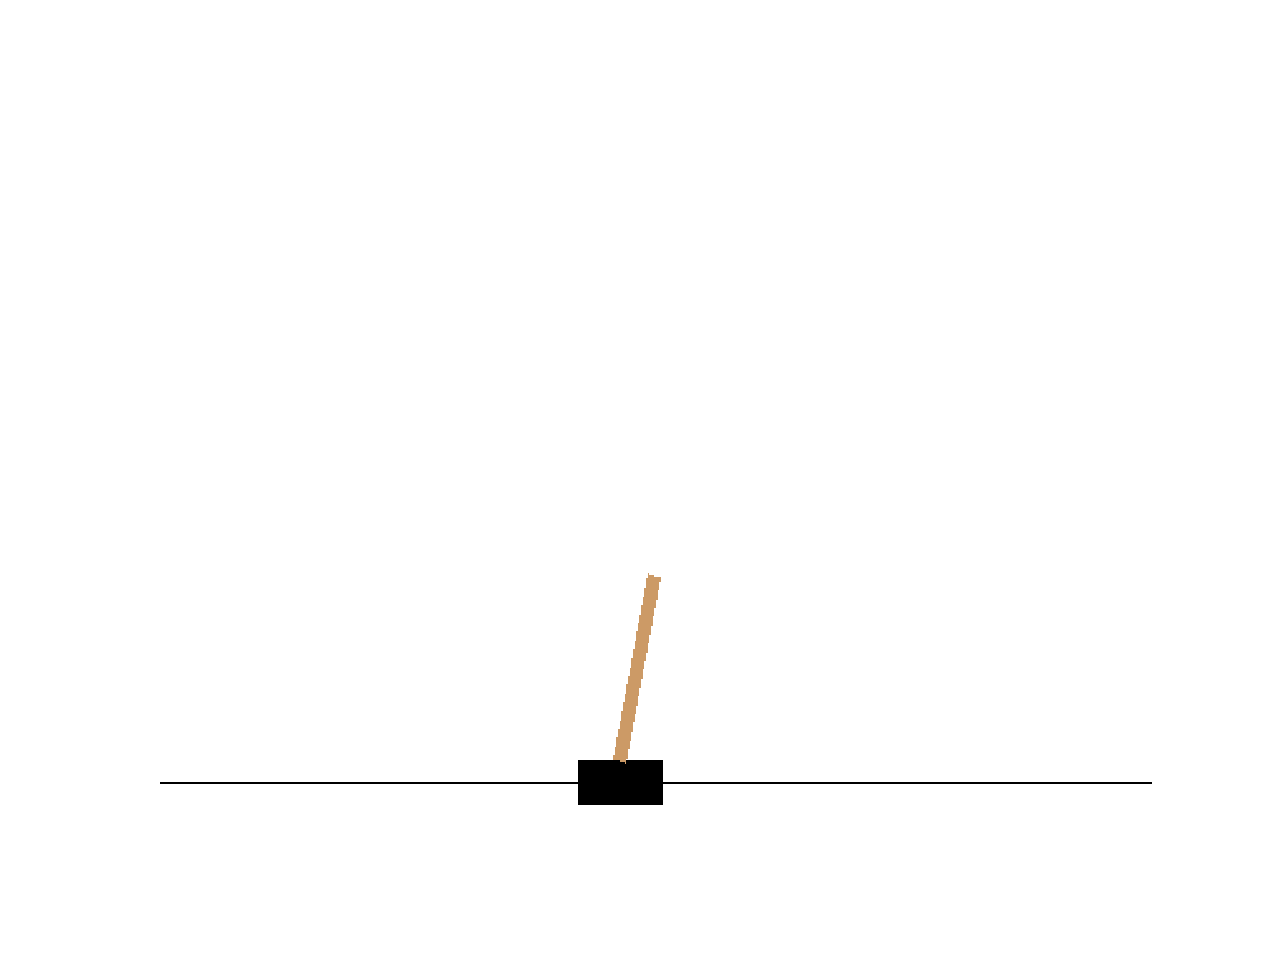

In [42]:
frames = render_policy_net("./my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames)
plt.show()

**Question** Does it seem like this learned the simple policy as before? Justify your answer.

Now, let's see if we can utilize Q-learning with a neural network policy to make our performance better

# Exercise solutions

## 1. to 7.

See Appendix A.

## 8. BipedalWalker-v2

Exercise: _Use policy gradients to tackle OpenAI gym's "BipedalWalker-v2"._

In [1]:
import gym

In [2]:
env = gym.make("BipedalWalker-v2")

AttributeError: module 'gym.envs.box2d' has no attribute 'BipedalWalker'

Note: if you run into [this issue](https://github.com/openai/gym/issues/100) ("`module 'Box2D._Box2D' has no attribute 'RAND_LIMIT'`") when making the `BipedalWalker-v2` environment, then try this workaround:

```
$ pip uninstall Box2D-kengz
$ pip install git+https://github.com/pybox2d/pybox2d
```

In [3]:
obs = env.reset()

NameError: name 'env' is not defined

In [4]:
img = env.render(mode="rgb_array")

NameError: name 'env' is not defined

In [5]:
plt.imshow(img)
plt.axis("off")
plt.show()

NameError: name 'plt' is not defined

In [6]:
obs

NameError: name 'obs' is not defined

You can find the meaning of each of these 24 numbers in the [documentation](https://github.com/openai/gym/wiki/BipedalWalker-v2).

In [7]:
env.action_space

NameError: name 'env' is not defined

In [8]:
env.action_space.low

NameError: name 'env' is not defined

In [9]:
env.action_space.high

NameError: name 'env' is not defined

This is a 4D continuous action space controling each leg's hip torque and knee torque (from -1 to 1). To deal with a continuous action space, one method is to discretize it. For example, let's limit the possible torque values to these 3 values: -1.0, 0.0, and 1.0. This means that we are left with $3^4=81$ possible actions.

In [10]:
from itertools import product

In [11]:
possible_torques = np.array([-1.0, 0.0, 1.0])
possible_actions = np.array(list(product(possible_torques, possible_torques, possible_torques, possible_torques)))
possible_actions.shape

NameError: name 'np' is not defined

In [12]:
tf.reset_default_graph()

# 1. Specify the network architecture
n_inputs = env.observation_space.shape[0]  # == 24
n_hidden = 10
n_outputs = len(possible_actions) # == 625
initializer = tf.variance_scaling_initializer()

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.selu,
                         kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs,
                         kernel_initializer=initializer)
outputs = tf.nn.softmax(logits)

# 3. Select a random action based on the estimated probabilities
action_index = tf.squeeze(tf.multinomial(logits, num_samples=1), axis=-1)

# 4. Training
learning_rate = 0.01

y = tf.one_hot(action_index, depth=len(possible_actions))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

NameError: name 'tf' is not defined

Let's try running this policy network, although it is not trained yet.

In [13]:
def run_bipedal_walker(model_path=None, n_max_steps = 1000):
    env = gym.make("BipedalWalker-v2")
    frames = []
    with tf.Session() as sess:
        if model_path is None:
            init.run()
        else:
            saver.restore(sess, model_path)
        obs = env.reset()
        for step in range(n_max_steps):
            img = env.render(mode="rgb_array")
            frames.append(img)
            action_index_val = action_index.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            action = possible_actions[action_index_val]
            obs, reward, done, info = env.step(action[0])
            if done:
                break
    env.close()
    return frames

In [14]:
frames = run_bipedal_walker()
video = plot_animation(frames)
plt.show()

AttributeError: module 'gym.envs.box2d' has no attribute 'BipedalWalker'

Nope, it really can't walk. So let's train it!

In [15]:
n_games_per_update = 10
n_max_steps = 1000
n_iterations = 1000
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}/{}".format(iteration + 1, n_iterations), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_index_val, gradients_val = sess.run([action_index, gradients],
                                                           feed_dict={X: obs.reshape(1, n_inputs)})
                action = possible_actions[action_index_val]
                obs, reward, done, info = env.step(action[0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_bipedal_walker_pg.ckpt")

NameError: name 'tf' is not defined

In [16]:
frames = run_bipedal_walker("./my_bipedal_walker_pg.ckpt")
video = plot_animation(frames)
plt.show()

AttributeError: module 'gym.envs.box2d' has no attribute 'BipedalWalker'

Not the best walker, but at least it stays up and makes (slow) progress to the right.
A better solution for this problem is to use an actor-critic algorithm, as it does not require discretizing the action space, and it converges much faster. Check out this nice [blog post](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-actor-critic-models-f084612cfd69) by Yash Patel for more details.

## 9.

**Coming soon**